In [1]:
from __future__ import print_function

In [2]:
import torch

import cv2

import torch.optim as optim
import torch.nn as nn

import sys

import torchvision.transforms as transforms
from torch.autograd import Variable
import random

from torchvision import models
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [11]:
!jupyter nbconvert --to python models/MultiFrameCNN.ipynb
from models import MultiFrameCNN
reload(MultiFrameCNN)

[NbConvertApp] Converting notebook models/MultiFrameCNN.ipynb to python
[NbConvertApp] Writing 9935 bytes to models/MultiFrameCNN.py


<module 'models.MultiFrameCNN' from 'models/MultiFrameCNN.py'>

In [5]:
!jupyter nbconvert --to python dataset/VideoSequenceDataset.ipynb
from dataset import VideoSequenceDataset
reload(VideoSequenceDataset)

[NbConvertApp] Converting notebook dataset/VideoSequenceDataset.ipynb to python
[NbConvertApp] Writing 6383 bytes to dataset/VideoSequenceDataset.py


<module 'dataset.VideoSequenceDataset' from 'dataset/VideoSequenceDataset.pyc'>

In [6]:
def test(model, testDataset, cuda=True):
    model.eval()
    tot = 0
    cor = 0
    for i, (batch, labels) in enumerate(testDataset):
        if cuda:
            batch = batch.cuda()
            labels = labels.cuda()
        outputs=model(Variable(batch))
        _, pred = torch.max(outputs.data, 1)
        tot += labels.size(0)
        cor += (pred == labels).sum()
        
    print(cor, "/", tot, " : ", cor*1.0/tot*100, "%")
    

In [7]:
def train(model, optimizer, trainDataset, valDataset, trans, nbepoch=5, cuda=True):
    #criterion = nn.CrossEntropyLoss(Variable(torch.Tensor([1/5.2,1/5.2,1/5.2,1/5.2,1/5.2,0.2/5.2])))
    criterion = nn.CrossEntropyLoss()
    if cuda:
        model = model.cuda()
    for epoch in range(nbepoch):
        test(model, valDataset, cuda)
        model.train()
        lo = 0
        for i, (batch,labels) in enumerate(trainDataset):
            if cuda:
                batch = batch.cuda()
                labels = labels.cuda()
            
            outputs = model(Variable(batch))
            #label = torch.LongTensor([gesture])
            loss = criterion(outputs, Variable(labels))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            lo += loss.data[0]
            if i%5 == 0:
                print(lo/5.0)
                lo = 0
            if i%30 == 0:
                test(model, valDataset, cuda)
                model.train()

In [12]:
#model = MultiFrameCNN.MultiFrameResNet(MultiFrameCNN.BasicBlock, [2,2,2,2], num_classes=6, groups=3)
#model = MultiFrameCNN.DummyMultiFrame()
model = MultiFrameCNN.MultiFrameCNN(nbClasse=6,nbFrame=3)
#model.copyParameters(models.alexnet(pretrained=True))
#model = models.AlexNet(num_classes=6)
#model = model.cuda()

In [16]:
trans = transforms.Compose(
                (transforms.ToPILImage(),
                transforms.Resize(64),
                transforms.RandomCrop(64),
                transforms.ToTensor(),
                #transforms.Normalize(mean=[0.485, 0.456, 0.406,0.485, 0.456, 0.406,0.485, 0.456, 0.406],
                #                     std=[0.229, 0.224, 0.225,0.229, 0.224, 0.225,0.229, 0.224, 0.225]),
                )
                )

trainDataset = VideoSequenceDataset.VideoDataset(rep="/video/GestureSequence/", SequenceSize=3, batchSize=4, transform=trans, 
                concat=True, dropFrame=2)

#TODO create validation and test datasets !
testDataset = VideoSequenceDataset.VideoDataset(rep="/video/GestureTest/", SequenceSize=3, batchSize=4, transform=trans, 
            concat=True, dropFrame=2)

optimizer = optim.SGD( model.parameters(),lr=0.001, momentum=0.9, weight_decay=0.0005)

In [17]:
train(model,optimizer,trainDataset,testDataset,trans, nbepoch=3, cuda=True)

6 / 24  :  25.0 %
0.544179821014
6 / 24  :  25.0 %
2.09596662521
1.25184092522
1.22928540707
1.77816448212
1.3255613327
1.73466391563
5 / 24  :  20.8333333333 %
1.34766045809
1.47949767113
1.15928448439
1.56517037153
1.15791354179
1.28404269218
6 / 24  :  25.0 %
1.29331448078
1.85867009163
1.33957906961
1.61266293526
1.38341839314
0.985290670395
6 / 24  :  25.0 %
1.12513067722
1.18019281626
1.30469191074
1.16081725359
1.26238734722
0.928975987434
6 / 24  :  25.0 %
1.15145308971
1.63523384333
1.39794826508
1.33256348372
1.663380301
1.24031990767
5 / 24  :  20.8333333333 %
1.53640521765
1.19312403202
1.00331333876
1.37943968773
1.47200133801
1.23455315828
5 / 24  :  20.8333333333 %
1.68868405819
1.3856251359
0.999927949905
1.37356500626
0.889095890522
1.149241364
6 / 24  :  25.0 %
1.31703211069
1.35661904812
6 / 24  :  25.0 %
0.229866743088
5 / 24  :  20.8333333333 %
1.47329287529
1.74772080183
1.03896317482
1.13697628975
1.22142841816
1.17533187866
6 / 24  :  25.0 %
1.51145300865
1.1131

In [43]:
for i in trainDataset:
    a = i
    break

In [44]:
a[1]


 4
 5
 4
 2
[torch.LongTensor of size 4]

In [41]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

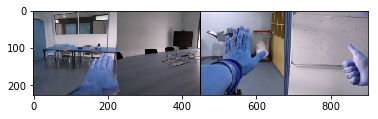

In [46]:
show(make_grid([a[0][0], a[0][1], a[0][2], a[0][3]], padding=1, normalize=False))